# JAX As Accelerated NumPy

In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

In [ ]:
x

In [ ]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

In [ ]:
def sum_of_squares(x):
  return jnp.sum(x**2)

In [ ]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

In [ ]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

In [ ]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux, has_aux=True)(x, y)

In [ ]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
  x[0] = 123
  return None

in_place_modify(x)
x

In [ ]:
in_place_modify(jnp.array(x))

In [ ]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [ ]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [ ]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [ ]:
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In [ ]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs), c='r')

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

# Just In Time Compilation with JAX

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:


global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

In [ ]:

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

In [ ]:
selu_jit = jax.jit(selu)

# Warm up
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

In [ ]:
# While loop conditioned on x and n with a jitted body.

@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

In [ ]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

print(g_jit_decorated(10, 20))

In [ ]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

# JAX - The Sharp Bits

In [ ]:
import numpy as np
from jax import grad, jit
from jax import lax
from jax import random
import jax
import jax.numpy as jnp

In [ ]:
def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect
  return x

# The side-effects appear during the first run
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

In [ ]:
g = 0.
def impure_uses_globals(x):
  return x + g

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))
g = 10.  # Update the global

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

In [ ]:
import jax.numpy as jnp
import jax.lax as lax
from jax import make_jaxpr

# lax.fori_loop
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0)) # expected result 45
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0)) # unexpected result 0

# lax.scan
def func11(arr, extra):
    ones = jnp.ones(arr.shape)
    def body(carry, aelems):
        ae1, ae2 = aelems
        return (carry + ae1 * ae2 + extra, carry)
    return lax.scan(body, 0., (arr, ones))
make_jaxpr(func11)(jnp.arange(16), 5.)
# make_jaxpr(func11)(iter(range(16)), 5.) # throws error

# lax.cond
array_operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, array_operand)
iter_operand = iter(range(10))
# lax.cond(True, lambda x: next(x)+1, lambda x: next(x)-1, iter_operand) # throws error

In [ ]:
numpy_array = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)

In [ ]:
%xmode Minimal

In [ ]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
jax_array[1, :] = 1.0

In [ ]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

In [ ]:
print("original array unchanged:\n", jax_array)

In [ ]:
jnp.arange(10)[11]

In [ ]:
jnp.sum([1, 2, 3])

In [ ]:
def permissive_sum(x):
  return jnp.sum(jnp.array(x))

x = list(range(10))
permissive_sum(x)

In [ ]:
from jax import random
key = random.PRNGKey(0)
key

In [ ]:
print(random.normal(key, shape=(1,)))
print(key)
# No no no!
print(random.normal(key, shape=(1,)))
print(key)

In [ ]:
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

In [ ]:
print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

In [ ]:
key, *subkeys = random.split(key, 4)
for subkey in subkeys:
  print(random.normal(subkey, shape=(1,)))

In [ ]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

In [ ]:
@jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x

print(f(3))

In [ ]:
@jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y

print(g(jnp.array([1., 2., 3.])))

In [ ]:
@jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
f(2)

In [ ]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))

In [ ]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jit(f, static_argnums=(1,))

f(jnp.array([2., 3., 4.]), 2)

In [ ]:
def cond(pred, true_fun, false_fun, operand):
  if pred:
    return true_fun(operand)
  else:
    return false_fun(operand)

In [ ]:
from jax import lax

operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, operand)
# --> array([1.], dtype=float32)
lax.cond(False, lambda x: x+1, lambda x: x-1, operand)
# --> array([-1.], dtype=float32)

In [ ]:
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

In [ ]:
init_val = 0
cond_fun = lambda x: x<10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)
# --> array(10, dtype=int32)

In [ ]:
def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val

init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
lax.fori_loop(start, stop, body_fun, init_val)
# --> array(45, dtype=int32

In [ ]:
@jax.jit
def nansum_2(x):
  mask = ~jnp.isnan(x)  # boolean mask selecting non-nan values
  return jnp.where(mask, x, 0).sum()

x = jnp.array([1, 2, jnp.nan, 3, 4])
print(nansum_2(x))

# How to Think in JAX

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

In [ ]:
import jax.numpy as jnp
jnp.add(1, 1.0)

In [ ]:
from jax import lax
lax.add(1, 1.0)

In [ ]:
lax.add(jnp.float32(1), 1.0)

In [ ]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

In [ ]:
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy
result[0, 0]

In [ ]:
import jax.numpy as jnp
from jax import jit

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)


norm_compiled = jit(norm)

In [ ]:
X = jnp.array(np.random.rand(10000, 10))

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

In [ ]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

In [ ]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

In [ ]:
f(1, False)

Just as values can be either static or traced, operations can be static or traced.

Static operations are evaluated at compile-time in Python; traced operations are compiled & evaluated at run-time in XLA.

Use numpy for operations that you want to be static; use jax.numpy for operations that you want to be traced

In [ ]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
  return x.reshape((np.prod(x.shape),))

f(x)

In [ ]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

# Automatic Vectorization in JAX

In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

In [ ]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

In [ ]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

In [ ]:
def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

In JAX, the jax.vmap transformation is designed to generate such a vectorized implementation of a function automatically

In [ ]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

In [ ]:
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

In [ ]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

In [ ]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)


In the context of JAX (Just Another eXperiment), a library for high-performance numerical computing, a transformation refers to a function or set of functions that operate on a computation and modify its behavior. JAX is particularly well-known for its ability to automatically transform numerical Python code (using NumPy and related libraries) to execute on accelerators like GPUs and TPUs, enabling efficient and scalable numerical computing.

There are two main types of transformations in JAX:

Function Transformations (jit, grad, vmap, etc.): JAX provides a set of higher-order functions that transform a given function into a new function with specific properties. Some key function transformations include:

jit (Just-In-Time Compilation): Compiles a function to accelerate its execution, often targeting accelerators like GPUs.

grad (Automatic Differentiation): Computes the gradient of a function, which is useful for optimization tasks like training machine learning models.

vmap (Vectorization Mapping): Maps a function over array axes to enable automatic parallelization.

pmap (Parallel Mapping): Parallelizes a function across multiple devices or cores.

lax.scan: Performs a scan operation over array elements.

In [ ]:
import jax

f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

In [ ]:
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

In [ ]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

In [ ]:
import jax.numpy as jnp

def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

In [ ]:
# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

In [ ]:
# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

In [ ]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((target - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

# But td_update will not compute a TD(0) update, because the gradient computation will include the dependency of target on 

delta_theta

In [ ]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((jax.lax.stop_gradient(target) - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

In [ ]:
s_grad = jax.grad(value_fn)(theta, s_tm1)
delta_theta_original_calculation = (r_t + value_fn(theta, s_t) - value_fn(theta, s_tm1)) * s_grad

delta_theta_original_calculation # [1.2, 2.4, -1.2], same as `delta_theta`

The straight-through estimator is a trick for defining a ‘gradient’ of a function that is otherwise non-differentiable

In [ ]:
def f(x):
  return jnp.round(x)  # non-differentiable

def straight_through_f(x):
  # Create an exactly-zero expression with Sterbenz lemma that has
  # an exactly-one gradient.
  zero = x - jax.lax.stop_gradient(x)
  return zero + jax.lax.stop_gradient(f(x))

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

In [ ]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

In [ ]:
dtdloss_dtheta = jax.grad(td_loss)

dtdloss_dtheta(theta, s_tm1, r_t, s_t)

inefficient_perex_grads = jax.vmap(dtdloss_dtheta, in_axes=(None, 0, 0, 0))

inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

In [ ]:
%timeit inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()
%timeit perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()

# Working with Pytrees

a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.

In [3]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x00000187EB799180>] has 3 leaves: [1, 'a', <object object at 0x00000187EB799180>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [ ]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

In [ ]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

In [4]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [5]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [6]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

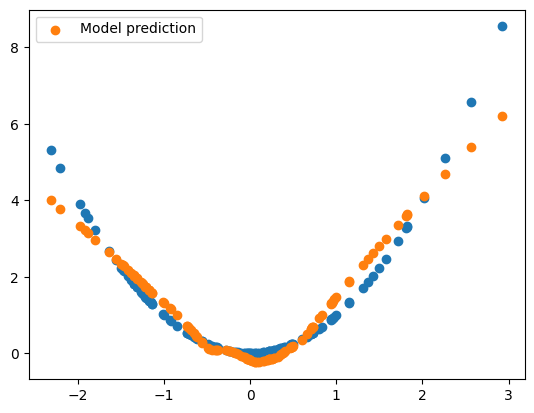

In [7]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

In [8]:
import collections
ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
for key_path, value in flattened:
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


In [9]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [11]:


try:
    jax.tree_map(lambda x: x + 1, [
        MyContainer('Alice', 1, 2, 3),
        MyContainer('Bob', 4, 5, 6)
    ])
except TypeError as e:
    print(f'TypeError: {e}')

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'


In [12]:
from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [13]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyContainer container{jax.tree_util.keystr(key_path)}: {value}')

MyContainer container[<flat index 0>]: 1
MyContainer container[<flat index 1>]: 2
MyContainer container[<flat index 2>]: 3


In [14]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

In [18]:
jax.tree_map(lambda x: str(x) + " you" , [
        MyOtherContainer('Alice', 1, 2, 3),
        MyOtherContainer('Bob', 4, 5, 6)
    ])

[MyOtherContainer(name='Alice you', a='1 you', b='2 you', c='3 you'),
 MyOtherContainer(name='Bob you', a='4 you', b='5 you', c='6 you')]

# Parallel Evaluation in JAX

# Stateful Computations in JAX

In [1]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


In [2]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


In [3]:
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In [4]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


In [5]:
from typing import NamedTuple

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


def init(rng) -> Params:
    """Returns the initial model params."""
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """Computes the least squares error of the model's predictions on x against y."""
    pred = params.weight * x + params.bias
    return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
    """Performs one SGD update step on params using the given data."""
    grad = jax.grad(loss)(params, x, y)

    # If we were using Adam or another stateful optimizer,
    # we would also do something like
    # ```
    # updates, new_optimizer_state = optimizer(grad, optimizer_state)
    # ```
    # and then use `updates` instead of `grad` to actually update the params.
    # (And we'd include `new_optimizer_state` in the output, naturally.)

    new_params = jax.tree_map(
        lambda param, g: param - g * LEARNING_RATE, params, grad)

    return new_params

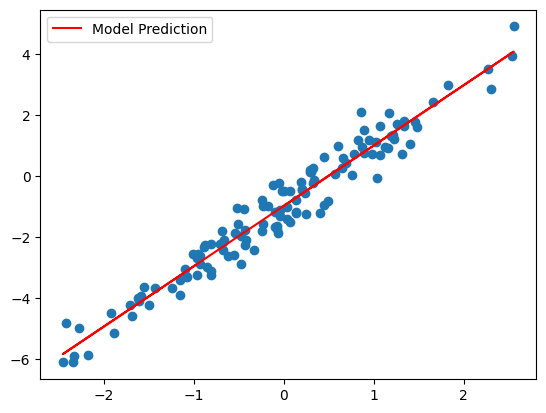

In [6]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();